<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 9: Classification Methods</h2></center>
<br>

In this tutorial we study how to implement a range of classification methods in Python.  We use a customer relationship management (CRM) dataset that refers to information related to customer acquisition and profitability.  Some aspects of the data and the corresponding business problems are discussed in lecture 9.

<a class="buttom" href="#Data:-Customer-Acquisition">Data: Customer Acquisition</a> <br>
<a class="buttom" href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a class="buttom" href="#Predictor-Processing">Predictor Processing</a> <br>
<a class="buttom" href="#Logistic-Regression">Logistic Regression</a> <br>
<a class="buttom" href="#Gaussian-Discriminant-Analysis">Gaussian Discriminant Analysis</a> <br>
<a class="buttom" href="#K-Nearest-Neighbours-Classifier">K-Nearest Neighbours Classifier</a> <br>
<a class="buttom" href="#Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following imports and settings.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sns.set_context('notebook') 
sns.set_style('ticks')
%matplotlib inline

## Data: Customer Acquisition

In [2]:
data = pd.read_excel('Datasets/CustomerAcquisition.xls', index_col=[0])
data.head(10)

,Acquisition,First_Purchase,CLV,Duration,Censor,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Crossbuy,Frequency,Frequency_SQ
Customer,,,,,,,,,,,,,,,
1,1,433.64,0.0000,384,0,760.36,578147.33,1,30.16,1240,2309.79,5335129.84,5,2,4
2,0,0.00,0.0000,0,0,147.70,21815.29,1,39.80,166,0.00,0.00,0,0,0
3,0,0.00,0.0000,0,0,252.56,63786.55,1,54.93,1016,0.00,0.00,0,0,0
4,1,225.84,5.7316,730,1,609.73,371770.67,1,45.83,122,2192.59,4807450.91,2,12,144
5,1,363.04,0.0000,579,0,672.36,452067.97,1,69.03,313,801.14,641825.30,4,7,49
6,0,0.00,0.0000,0,0,435.57,189721.22,0,22.54,359,0.00,0.00,0,0,0
7,0,0.00,0.0000,0,0,362.90,131696.41,0,32.97,902,0.00,0.00,0,0,0
8,0,0.00,0.0000,0,0,883.54,780642.93,0,22.48,264,0.00,0.00,0,0,0
9,1,599.30,6.9161,730,1,452.35,204620.52,1,17.98,1782,1340.75,1797610.56,1,11,121


We process the data as follows. Note that only five of the variables in the dataset (including the response) are relevant for customer acquisition modelling, since the rest are variables measured only after a customer is acquired.

As per usual, we split the data into training (70%) and test (30%) sets before proceeding. 

In [3]:
from sklearn.model_selection import train_test_split

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=1)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

response = 'Acquisition'
predictors = ['Acq_Expense', 'Revenue', 'Employees', 'Industry']

y_train = train[response]
y_test = test[response]
X_train = train[predictors]
X_test = test[predictors]

## Exploratory Data Analysis

The company acquired 56.3% of prospects in the training data as customers: 

In [4]:
round(y_train.mean(), 3)

0.563

The next cell displays the descriptive statistics for the predictors.  We add the sample skewness and kurtosis to the table to verify how close the empirical distribution of numerical predictor is to the normal distribution. 

The acquisition expense and revenue are approximately symmetric, but seem to have lower kurtosis (thinner tails) that a normally distributed variable. The number of employees variable is positively skewed and also displays low kurtosis. 

62.3% of prospects are in the B2B (business-to-business) industry.  

In [5]:
descriptive = X_train.describe()
descriptive.loc['skew', :] = X_train.skew()
descriptive.loc['kurt', :] = X_train.kurt()
descriptive.round(3)

,Acq_Expense,Revenue,Employees,Industry
count,350.000,350.000,350.000,350.000
mean,501.141,39.788,641.603,0.623
std,221.056,16.978,458.740,0.485
min,14.210,1.860,4.000,0.000
25%,339.295,28.038,271.000,0.000
50%,498.245,40.060,532.500,1.000
75%,679.875,52.165,958.500,1.000
max,963.680,76.770,1968.000,1.000
skew,-0.013,-0.061,0.692,-0.509
kurt,-0.773,-0.695,-0.546,-1.751


The plots below use functions from the statlearning library.   First, we produce the histograms to further explore the univariate distribution of the numerical predictors.  

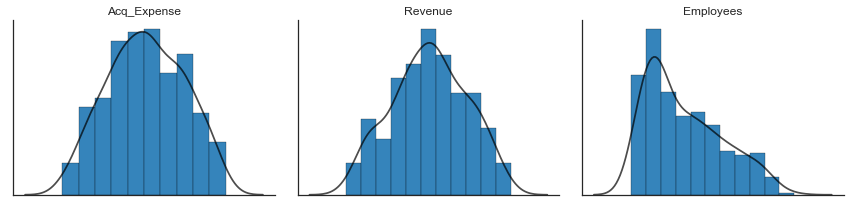

In [6]:
from statlearning import plot_histograms
plot_histograms(train[predictors[:3]])
plt.show()

To explore the relationship between the numerical predictors and the respose, we use univariate logistic regression. The results show that the acquisition expense may be strongly associated with a higher probability of acquisition. 

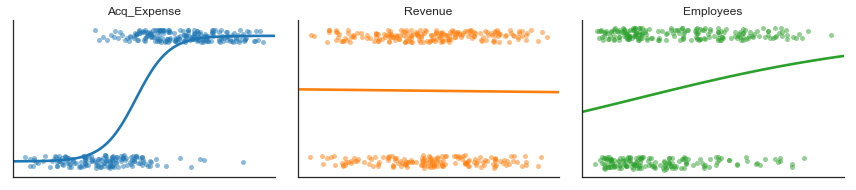

In [7]:
from statlearning import plot_logistic_regressions

plot_logistic_regressions(train[predictors[:3]], y_train)
plt.show()

Here are the class-conditional distributions accross the predictors.

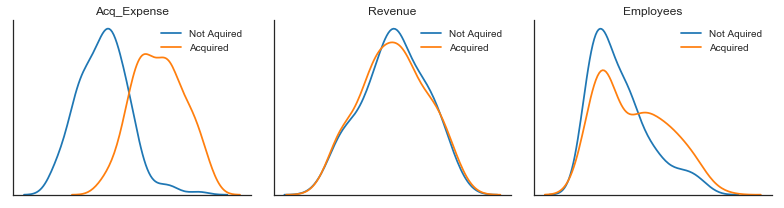

In [8]:
from statlearning import plot_conditional_distributions

plot_conditional_distributions(train[predictors[:3]], y_train, labels=['Not Aquired', 'Acquired'])
plt.show()

A higher proportion of B2B prospects (59.2%) is acquired compared to the non-B2B prospects (51.5%):

In [9]:
table=pd.crosstab(train['Acquisition'], train['Industry'])
table = (table/table.sum()).round(3)
table

Industry,0,1
Acquisition,,
0,0.485,0.408
1,0.515,0.592


## Predictor Processing

In this tutorial, the only processing step that we apply to the predictors is standardising. Transformations may be useful in some cases for classification, but cross validation suggested that they do not lead to improvements in this application. 

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# We transform numpy arrays into a pandas frameworks
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Logistic Regression

The basic command to estimate a [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with Scikit-Learn is as follows.  

In [11]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

From the output, we notice that by default the method includes an $\ell_2$ penalty, which is not necessarily the behaviour that we would expect. The tuning parameter <TT>C</TT> is the inverse of the regularisation strength, so setting it to an extremely large value will lead to essentially no regularisation:

In [12]:
logit = LogisticRegression(C=1e10)
logit.fit(X_train, y_train)

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Here we implement cross-validated $\ell_1$ and $\ell_2$ regularised logistic regression, with 20 values of the penalty weight tuning parameters:

In [13]:
from sklearn.linear_model import LogisticRegressionCV

logit_l1 = LogisticRegressionCV(Cs = 20, penalty='l1', solver='liblinear', scoring='neg_log_loss')
logit_l1.fit(X_train, y_train)

logit_l2 = LogisticRegressionCV(Cs = 20, penalty='l2', scoring='neg_log_loss')
logit_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=20, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
           verbose=0)

We now plot the estimated coefficients for the $\ell_1$ regularised logistic regression using a function from the statlearning library.

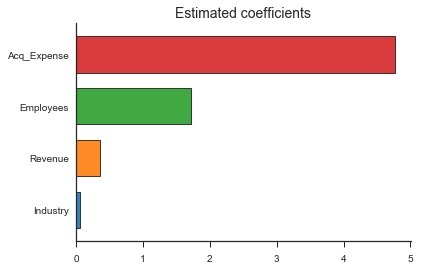

In [14]:
from statlearning import plot_coefficients

plot_coefficients(logit_l1, predictors)
plt.show()

## Gaussian Discriminant Analysis

Since Gaussian Discriminant Analysis relies on the assumption of normality, we exclude the binary predictor for this class of models.

We use the [<TT>LinearDiscriminantAnalysis</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) class to fit the linear DA and [<TT>QuadraticDiscriminantAnalysis</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html) class to fit the quadratic DA.

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train.iloc[:,:3], y_train)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train.iloc[:,:3], y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

For regularisation, we need to write a function to select the tuning parameter by cross validation:

In [16]:
from sklearn.model_selection import cross_val_score

def qda_cv(X_train, y_train):
    
    alphas  = np.linspace(0, 1, 21)
    best_score = -np.inf
    
    for alpha in alphas:
        qda = QuadraticDiscriminantAnalysis(reg_param=alpha)
        score = np.mean(cross_val_score(qda, X_train, y_train, cv=10, scoring = 'accuracy'))
        if score >= best_score:
            best = qda
            best_score = score
    
    return qda.fit(X_train, y_train)
        
qda_reg = qda_cv(X_train.iloc[:,:3], y_train)

## K-Nearest Neighbours Classifier

For the KNN classifier, we also need to write a function to select the number of neighbours by cross validation. We use the [<TT>KNeighborsClassifier</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) method in the fitting procedure.

In [17]:
from sklearn.neighbors import KNeighborsClassifier

def knn_cv(X_train, y_train):
    
    neighbours = np.arange(1, 51)
    best_score = 0
    
    for k in neighbours:
        knn = KNeighborsClassifier(n_neighbors = k ,  metric='mahalanobis', metric_params={'V': X_train.cov()})
        score = np.mean(cross_val_score(knn, X_train, y_train, cv=10, scoring = 'accuracy'))
        if score >= best_score:
            best = knn
            best_score = score
    
    return best
        
knn = knn_cv(X_train, y_train) 
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='mahalanobis',
           metric_params={'V':           0         1         2         3
0  1.002865 -0.106509 -0.066126  0.056397
1 -0.106509  1.002865  0.081742 -0.085830
2 -0.066126  0.081742  1.002865  0.037950
3  0.056397 -0.085830  0.037950  1.002865},
           n_jobs=1, n_neighbors=48, p=2, weights='uniform')

## Model Evaluation

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score

columns=['Error rate', 'True Pos. Rate', 'True Neg. Rate', 'AUC', 'Precision']
rows=['Logistic', 'L1 regularised', 'L2 regularised', 'KNN', 'LDA', 'QDA', 'Regularised QDA']
results=pd.DataFrame(0.0, columns=columns, index=rows) 


methods=[logit, logit_l1, logit_l2, knn, lda, qda, qda_reg]

for i, method in enumerate(methods):
    
    if i < 4:
        y_pred = method.predict(X_test)
        y_prob = method.predict_proba(X_test)
    else:
        y_pred = method.predict(X_test.iloc[:,:3])
        y_prob = method.predict_proba(X_test.iloc[:,:3])
    
    confusion  = confusion_matrix(y_test, y_pred) 
    error_rate =  1 - accuracy_score(y_test, y_pred)

    results.iloc[i,0]=  error_rate
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,3]=  roc_auc_score(y_test, y_prob[:,1])
    results.iloc[i,4]=  precision_score(y_test, y_pred)

results.round(3)

,Error rate,True Pos. Rate,True Neg. Rate,AUC,Precision
Logistic,0.087,0.937,0.873,0.968,0.927
L1 regularised,0.087,0.937,0.873,0.968,0.927
L2 regularised,0.087,0.937,0.873,0.968,0.927
KNN,0.100,0.916,0.873,0.958,0.926
LDA,0.087,0.937,0.873,0.968,0.927
QDA,0.093,0.937,0.855,0.968,0.918
Regularised QDA,0.100,0.968,0.782,0.964,0.885


KNN and Regularized QDA perform worse than the other methods, with the highest Error rate and the lowest AUC (area under the ROC curve).  We now plot the ROC curves:

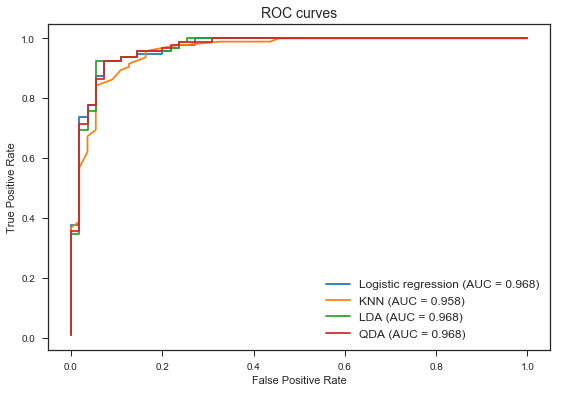

In [19]:
from sklearn.metrics import roc_curve

labels=['Logistic regression', 'KNN', 'LDA', 'QDA']
methods=[logit, knn, lda, qda]

fig, ax= plt.subplots(figsize=(9,6))

for i, method in enumerate(methods):
    if i < 2:
        y_prob = method.predict_proba(X_test)
    else:
        y_prob = method.predict_proba(X_test.iloc[:,:3])
        
    fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
    auc = roc_auc_score(y_test, y_prob[:,1])
    ax.plot(fpr, tpr, label=labels[i] + ' (AUC = {:.3f})'.format(auc))
    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curves', fontsize=14)
plt.legend(loc=0, fontsize=12)
plt.show()